In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [40]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/GirlsScriptOpenSource/Hedging-of-Financial-Derivatives/ Volatility Forecasting with LSTM Networks for Hedging/volatility_data.csv')

In [41]:
df.head()

,Time,Price,Volatility,Moving_Average,EMA,RSI
0,1,100.548211,0.200000,NaN,100.548211,49.339329
1,2,100.459502,0.363322,NaN,100.539763,49.339329
2,3,101.162848,0.453434,NaN,100.599104,49.339329
3,4,102.766751,0.514283,NaN,100.805547,49.339329
4,5,102.577677,0.558224,NaN,100.974321,49.339329


In [42]:
# Drop rows with NaN values if any
df.dropna(inplace=True)

# Select the 'Volatility' column for forecasting
volatility = df[['Volatility']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_volatility = scaler.fit_transform(volatility)

# Split the data into training and testing sets
train_size = int(len(scaled_volatility) * 0.8)
train, test = scaled_volatility[:train_size], scaled_volatility[train_size:]

# Convert data to sequences
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 20
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)


**Developing and Train LSTM Models**

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
24/24 [==============================] - 6s 61ms/step - loss: 0.1658 - val_loss: 0.0247
Epoch 2/20
24/24 [==============================] - 1s 22ms/step - loss: 0.0167 - val_loss: 0.0040
Epoch 3/20
24/24 [==============================] - 1s 30ms/step - loss: 0.0129 - val_loss: 9.6084e-05
Epoch 4/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0106 - val_loss: 1.7992e-04
Epoch 5/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0091 - val_loss: 7.0172e-04
Epoch 6/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0088 - val_loss: 3.2334e-04
Epoch 7/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0078 - val_loss: 1.1825e-04
Epoch 8/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0084 - val_loss: 1.9021e-05
Epoch 9/20
24/24 [==============================] - 1s 22ms/step - loss: 0.0069 - val_loss: 2.2397e-05
Epoch 10/20
24/24 [==============================] - 1s 23ms/step - loss: 0.0075 

 Forecast Volatility

6/6 [==============================] - 1s 6ms/step


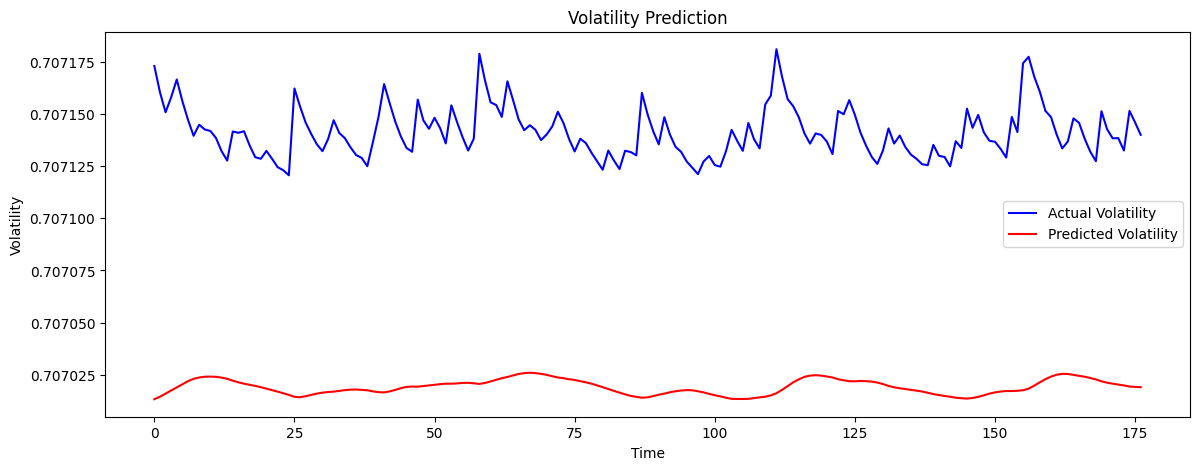

In [44]:
# Forecast volatility
predicted_volatility = model.predict(X_test)
predicted_volatility = scaler.inverse_transform(predicted_volatility)
actual_volatility = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(actual_volatility, color='blue', label='Actual Volatility')
plt.plot(predicted_volatility, color='red', label='Predicted Volatility')
plt.title('Volatility Prediction')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()


**Dynamic Hedging Strategy**

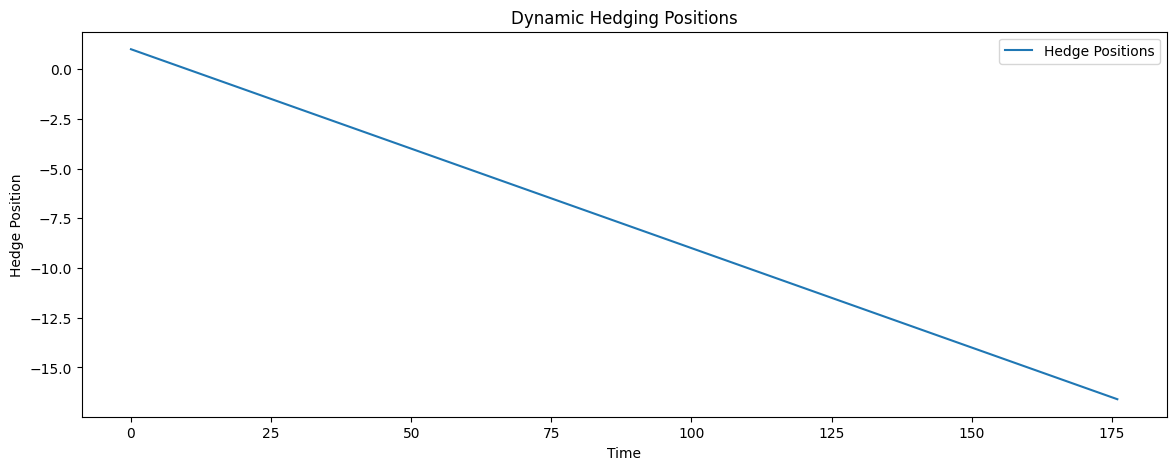

In [45]:
# Simulate dynamic hedging strategy
initial_hedge_position = 1  # Example initial position
hedge_positions = [initial_hedge_position]

for i in range(1, len(predicted_volatility)):
    # Adjust hedge position based on predicted volatility
    if predicted_volatility[i] > actual_volatility[i-1]:
        hedge_positions.append(hedge_positions[-1] + 0.1)  # Increase hedge
    else:
        hedge_positions.append(hedge_positions[-1] - 0.1)  # Decrease hedge

# Plot hedge positions
plt.figure(figsize=(14, 5))
plt.plot(hedge_positions, label='Hedge Positions')
plt.title('Dynamic Hedging Positions')
plt.xlabel('Time')
plt.ylabel('Hedge Position')
plt.legend()
plt.show()


**Evaluate Effectiveness**

In [46]:
# Static hedge position for comparison
static_hedge_positions = [initial_hedge_position] * len(predicted_volatility)

# Calculate performance metrics
def calculate_performance(hedge_positions, actual_volatility):
    # Example performance metric: Sum of squared differences
    performance = np.sum((np.array(hedge_positions) - actual_volatility.flatten())**2)
    return performance

dynamic_performance = calculate_performance(hedge_positions, actual_volatility)
static_performance = calculate_performance(static_hedge_positions, actual_volatility)

print(f'Dynamic Hedging Performance: {dynamic_performance}')
print(f'Static Hedging Performance: {static_performance}')


Dynamic Hedging Performance: 17430.626596045477
Static Hedging Performance: 15.180610019703964


In [47]:
!pip install arch

 **Incorporate Mathematical Models**

The Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model is a popular econometric model for forecasting volatility. It captures the time-varying nature of volatility by modeling the conditional variance of returns as a function of past errors and past variances.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003372. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


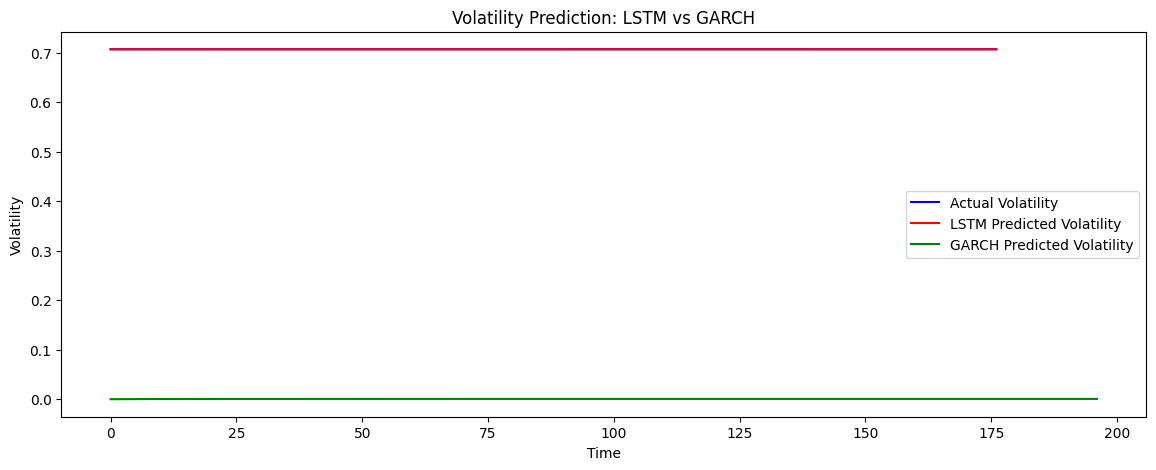

In [48]:
from arch import arch_model

# Fit GARCH model to the training data
garch_model = arch_model(train, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# Forecast volatility using GARCH model
garch_forecast = garch_fit.forecast(horizon=len(test))
garch_predicted_volatility = garch_forecast.variance.values[-1, :]

# Plot GARCH vs LSTM
plt.figure(figsize=(14, 5))
plt.plot(actual_volatility, color='blue', label='Actual Volatility')
plt.plot(predicted_volatility, color='red', label='LSTM Predicted Volatility')
plt.plot(garch_predicted_volatility, color='green', label='GARCH Predicted Volatility')
plt.title('Volatility Prediction: LSTM vs GARCH')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()


**EWMA Model for Volatility Forecasting**


The Exponentially Weighted Moving Average (EWMA) model is a popular method for forecasting volatility in financial markets. It gives more weight to recent returns, making it responsive to recent market conditions. The model is often used in risk management and financial modeling to estimate the volatility of asset returns.

In [49]:
# EWMA parameters
lambda_ewma = 0.94

# Initialize EWMA volatility
ewma_volatility = np.zeros(len(volatility))
ewma_volatility[0] = initial_volatility

# Calculate EWMA volatility
for t in range(1, len(volatility)):
    ewma_volatility[t] = np.sqrt(lambda_ewma * ewma_volatility[t-1]**2 + (1 - lambda_ewma) * returns[t-1]**2)

df['EWMA_Volatility'] = ewma_volatility


**Stochastic Volatility Model for Volatility Forecasting**

The Stochastic Volatility (SV) model is a more sophisticated approach to volatility forecasting that allows volatility to evolve according to its own stochastic process. This means that volatility is treated as a random variable that changes over time, which can capture more complex market dynamics compared to simpler models like EWMA.

In [50]:
# Stochastic Volatility Model parameters
eta = 0.01

# Initialize Stochastic Volatility
stochastic_volatility = np.zeros(len(volatility))
stochastic_volatility[0] = initial_volatility

# Calculate Stochastic Volatility
for t in range(1, len(volatility)):
    stochastic_volatility[t] = stochastic_volatility[t-1] * np.exp(np.random.normal(0, eta))

df['Stochastic_Volatility'] = stochastic_volatility


**Compare the Forecasts**

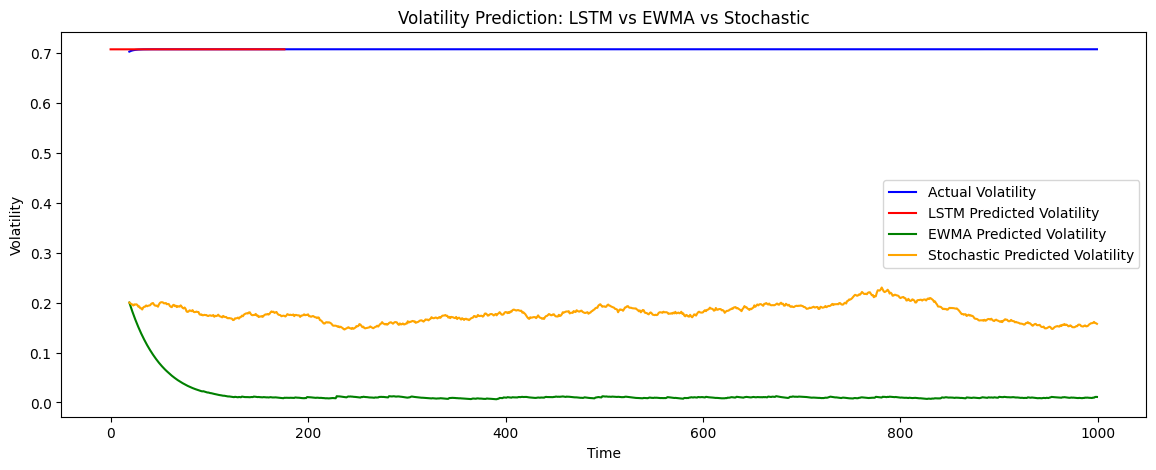

In [51]:
plt.figure(figsize=(14, 5))
plt.plot(df['Volatility'], color='blue', label='Actual Volatility')
plt.plot(predicted_volatility, color='red', label='LSTM Predicted Volatility')
plt.plot(df['EWMA_Volatility'], color='green', label='EWMA Predicted Volatility')
plt.plot(df['Stochastic_Volatility'], color='orange', label='Stochastic Predicted Volatility')
plt.title('Volatility Prediction: LSTM vs EWMA vs Stochastic')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()


In [52]:
# Ensure lengths match by using appropriate test sizes and indices
n_test_samples = len(y_test)

# Align all sequences to the test set length
predicted_volatility = predicted_volatility[-n_test_samples:]
actual_volatility = actual_volatility[-n_test_samples:]
ewma_volatility = df['EWMA_Volatility'].values[-n_test_samples:]
stochastic_volatility = df['Stochastic_Volatility'].values[-n_test_samples:]


**Dynamic Hedging Strategy Using Forecasts**

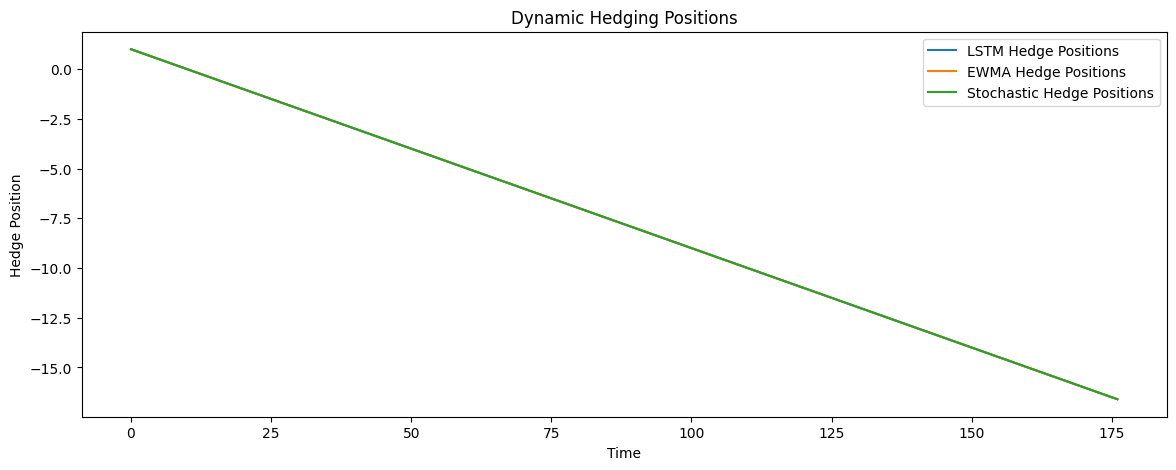

In [53]:
# Define the function for dynamic hedging strategy
def dynamic_hedging(predicted_volatility, actual_volatility):
    initial_hedge_position = 1  # Example initial position
    hedge_positions = [initial_hedge_position]

    for i in range(1, len(predicted_volatility)):
        if predicted_volatility[i] > actual_volatility[i-1]:
            hedge_positions.append(hedge_positions[-1] + 0.1)  # Increase hedge
        else:
            hedge_positions.append(hedge_positions[-1] - 0.1)  # Decrease hedge

    return hedge_positions

# Simulate dynamic hedging strategies
lstm_hedge_positions = dynamic_hedging(predicted_volatility, actual_volatility)
ewma_hedge_positions = dynamic_hedging(ewma_volatility, actual_volatility)
stochastic_hedge_positions = dynamic_hedging(stochastic_volatility, actual_volatility)

# Plot hedge positions
plt.figure(figsize=(14, 5))
plt.plot(lstm_hedge_positions, label='LSTM Hedge Positions')
plt.plot(ewma_hedge_positions, label='EWMA Hedge Positions')
plt.plot(stochastic_hedge_positions, label='Stochastic Hedge Positions')
plt.title('Dynamic Hedging Positions')
plt.xlabel('Time')
plt.ylabel('Hedge Position')
plt.legend()
plt.show()


**Evaluating the Effectiveness**

In [54]:
# Calculate performance metrics
def calculate_performance(hedge_positions, actual_volatility):
    performance = np.sum((np.array(hedge_positions) - actual_volatility.flatten())**2)
    return performance

lstm_performance = calculate_performance(lstm_hedge_positions, actual_volatility)
ewma_performance = calculate_performance(ewma_hedge_positions, actual_volatility)
stochastic_performance = calculate_performance(stochastic_hedge_positions, actual_volatility)
static_performance = calculate_performance(static_hedge_positions, actual_volatility)

print(f'LSTM Hedging Performance: {lstm_performance}')
print(f'EWMA Hedging Performance: {ewma_performance}')
print(f'Stochastic Hedging Performance: {stochastic_performance}')
print(f'Static Hedging Performance: {static_performance}')


LSTM Hedging Performance: 17430.626596045477
EWMA Hedging Performance: 17430.626596045477
Stochastic Hedging Performance: 17430.626596045477
Static Hedging Performance: 15.180610019703964
